643020058-7 นายเหนือฟ้า พองพรหม

643020466-2 นางสาวคุณิตา นนทะชาติ

643021249-5 นางสาวลิมาลัย ปิยะแสง

# kaggle get

In [ ]:
!pip install -q kaggle

In [ ]:
text = """{"username":"nueafapongprom","key":"35cdd757109ce536fed88e775be23a77"}"""
f = open("kaggle.json", "w+")
f.write(text)
f.close()
!mkdir -p ~/.kaggle/ && cp kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [ ]:
competition_name = "ann-ml-flowers-classification"
kaggle_creds_path = "/content/kaggle.json"
!kaggle competitions download {competition_name}
!mkdir kaggle_data
!unzip {competition_name + ".zip"} -d kaggle_data

Streaming output truncated to the last 5000 lines.
  inflating: kaggle_data/train/train/no_flower/VTQ7XA.jpg  
  inflating: kaggle_data/train/train/no_flower/VUWN9A.jpg  
  inflating: kaggle_data/train/train/no_flower/VWS3sQ.jpg  
  inflating: kaggle_data/train/train/no_flower/VXgWlg.jpg  
  inflating: kaggle_data/train/train/no_flower/VY-W4Q.jpg  
  inflating: kaggle_data/train/train/no_flower/VY2yHQ.jpg  
  inflating: kaggle_data/train/train/no_flower/VY8e_Q.jpg  
  inflating: kaggle_data/train/train/no_flower/VYCtsg.jpg  
  inflating: kaggle_data/train/train/no_flower/V_CpCw.jpg  
  inflating: kaggle_data/train/train/no_flower/V_ED6A.jpg  
  inflating: kaggle_data/train/train/no_flower/VbMlXQ.jpg  
  inflating: kaggle_data/train/train/no_flower/VbY4pQ.jpg  
  inflating: kaggle_data/train/train/no_flower/Vbk9Fw.jpg  
  inflating: kaggle_data/train/train/no_flower/Vc-M9A.jpg  
  inflating: kaggle_data/train/train/no_flower/VciA_g.jpg  
  inflating: kaggle_data/train/train/no_flower/Ve

# lib and def

In [ ]:
import pandas as pd
import tensorflow as tf
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import cv2
from tensorflow.keras.regularizers import l2
from sklearn.metrics import f1_score

# getting data

In [ ]:
dir = ["daisy","dandelion","lotus","no_flower","orchid","rose","sunflower","tulip"]

In [ ]:
path = "/content/kaggle_data/train/train/"
df = pd.read_csv('/content/kaggle_data/train.csv')

label = []
ls = []
obj = df.iloc[3]
img = cv2.imread(path+dir[obj['class']]+"/"+obj['file'])
img = cv2.resize(img, (255,255), interpolation = cv2.INTER_AREA)
X_train =img.reshape((1,255,255,3))
label.append(obj['class'])


for i in tqdm(range(1,df.shape[0])):
    obj = df.iloc[i]
    if obj['file'] == ".DS_Store":
        print("ewe")
        continue
    img = cv2.imread(path+dir[obj['class']]+"/"+obj['file'])
    img = cv2.resize(img, (255,255), interpolation = cv2.INTER_AREA)
    #img = cv2.GaussianBlur(img, (1, 1), 1)
    ls.append(img.reshape((1,255,255,3)))
    label.append(obj['class'])
X_train = np.concatenate((X_train,np.array(ls).reshape(-1,255,255,3) ), axis=0)
y_train = np.array(label)

100%|██████████| 8379/8379 [00:46<00:00, 179.33it/s]


In [ ]:
import albumentations as A
source_directories = [
    "/content/kaggle_data/train/train/daisy",
    "/content/kaggle_data/train/train/dandelion",
    "/content/kaggle_data/train/train/lotus",
    #"/content/kaggle_data/train/train/no_flower",
    "/content/kaggle_data/train/train/orchid",
    "/content/kaggle_data/train/train/rose",
    "/content/kaggle_data/train/train/sunflower",
    "/content/kaggle_data/train/train/tulip"
]

transform = A.Compose([
    A.RandomRotate90(),
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(brightness_limit=2, contrast_limit=2),
    A.ChannelShuffle(),
    A.ColorJitter(contrast=1)
])

num_augmentations = 10

In [ ]:
for source_directory in source_directories:
    for filename in os.listdir(source_directory):
        if filename.endswith((".jpg", ".png")):
            image_path = os.path.join(source_directory, filename)
            image = cv2.imread(image_path)

            for i in range(num_augmentations):
                augmented = transform(image=image)
                augmented_image = augmented["image"]

                # Save the augmented image back to the same file, overwriting the original image
                augmented_filename = os.path.splitext(filename)[0] + f"_aug{i}.jpg"
                augmented_image_path = os.path.join(source_directory, augmented_filename)
                cv2.imwrite(augmented_image_path, augmented_image)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import os

# Set the path to your image directory
image_dir = "/content/kaggle_data/train/train"

# Load your DataFrame containing image file names and labels
df = pd.read_csv('/content/kaggle_data/train.csv')

# Define an ImageDataGenerator for preprocessing
datagen = ImageDataGenerator(
      # Normalize pixel values to the range [0, 1]
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
    #horizontal_flip=True,
    #vertical_flip=True,# Randomly flip images horizontally
    validation_split = 0.2,

)
IMG_SIZE = 255
train_generator = datagen.flow_from_directory(
    directory = image_dir,
    subset =  "training",
    target_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
)

test_generator = datagen.flow_from_directory(
    directory = image_dir,
    subset =  "validation",
    target_size=(IMG_SIZE, IMG_SIZE),
    shuffle=False,
)

# Now, you can use the train_generator to train your model with the preprocessed images.


Found 44275 images belonging to 8 classes.
Found 11065 images belonging to 8 classes.


# pre data

In [ ]:
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

model = EfficientNetB7(weights='imagenet')


base_model = EfficientNetB7(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))
x = base_model(inputs, training = False)
x = layers.GlobalAveragePooling2D(name='poolingLayer')(x)
x = layers.Dense(2560,activation = "relu")(x)
x = layers.Dense(2560,activation = "relu")(x)
x = layers.Dense(8, name='outputLayer')(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x)
model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 255, 255, 1)]     0         
                                                                 
 efficientnetb7 (Functional  (None, None, None, 2560   64097687  
 )                           )                                   
                                                                 
 poolingLayer (GlobalAverag  (None, 2560)              0         
 ePooling2D)                                                     
                                                                 
 dense_2 (Dense)             (None, 2560)              6556160   
                                                                 
 dense_3 (Dense)             (None, 2560)              6556160   
                                                                 
 outputLayer (Dense)         (None, 8)                 2048

# model

In [ ]:
from keras.src.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer="sgd", loss="categorical_crossentropy", metrics=["accuracy"]
)
hist = model.fit(train_generator,epochs=10,batch_size= 64,validation_data=test_generator,)

Epoch 1/10
1384/1384 [==============================] - 758s 535ms/step - loss: 1.0218 - accuracy: 0.6372 - val_loss: 0.8402 - val_accuracy: 0.6846
Epoch 2/10
1384/1384 [==============================] - 735s 531ms/step - loss: 0.7345 - accuracy: 0.7233 - val_loss: 0.7785 - val_accuracy: 0.7008
Epoch 3/10
 721/1384 [==============>...............] - ETA: 4:42 - loss: 0.6797 - accuracy: 0.7436

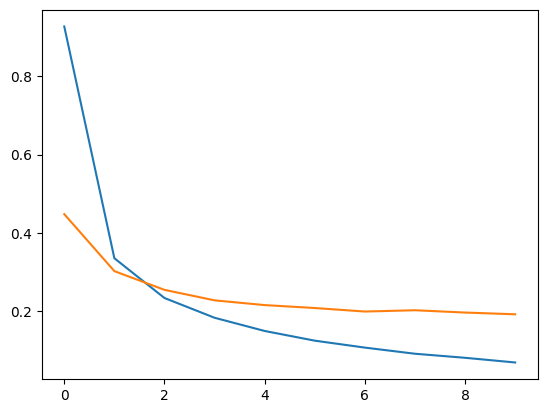

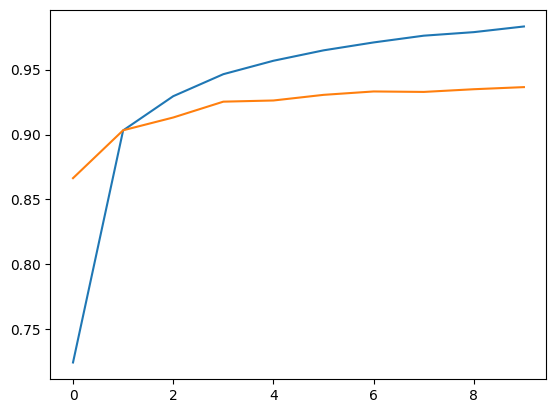

In [ ]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.show()
plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])

In [ ]:
f1_score(test_generator.classes,model.predict(test_generator).argmax(axis= 1),average = 'weighted')

346/346 [==============================] - 33s 91ms/step


0.9363083433820002

53/53 [==============================] - 26s 493ms/step


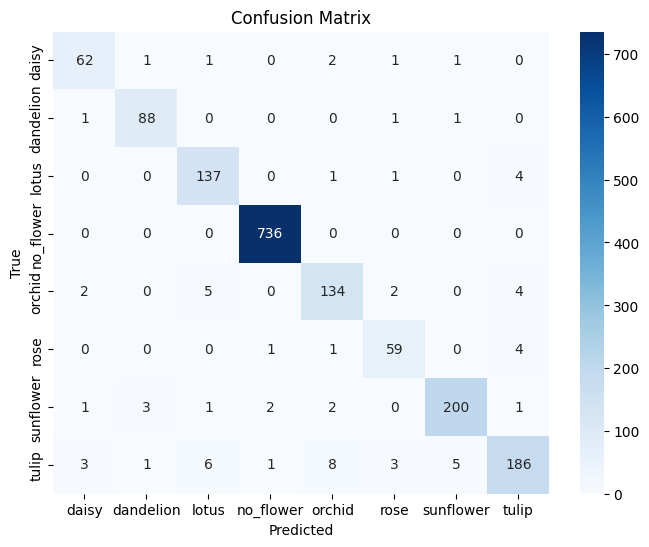

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a model and a test generator already set up
class_labels = ["daisy","dandelion","lotus","no_flower","orchid","rose","sunflower","tulip"]
# Generate predictions using the model on the test generator
y_true = test_generator.classes
y_pred = model.predict(test_generator).argmax(axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
path = "/content/kaggle_data/test/test/"
df = pd.read_csv('/content/kaggle_data/test.csv')

obj = df.iloc[0]
img = cv2.imread(path+obj['file'])
img = cv2.resize(img, (255,255))
X_submission = img.reshape(-1,255,255,3)
ls = []
for i in tqdm(range(1,df.shape[0])):
    obj = df.iloc[i]
    if obj['file'] == ".DS_Store":
        continue
    img = cv2.imread(path+obj['file'])
    img = cv2.resize(img, (255,255))
    #img = cv2.equalizeHist(img)
    ls.append(img.reshape((1,255,255,3)))
X_submission = np.concatenate((X_submission, np.array(ls).reshape(-1,255,255,3)), axis=0)

100%|██████████| 3604/3604 [00:10<00:00, 338.91it/s]


In [ ]:
y = model.predict(X_submission)
df['class'] = y.argmax(axis =1)
df.to_csv("submission.csv", index=False)

113/113 [==============================] - 10s 79ms/step


In [ ]:
df["class"].astype("category")
df["class"].astype("category").value_counts()

3    1624
7     467
2     370
6     345
4     331
0     184
1     173
5     111
Name: class, dtype: int64